# goal

- [ ] narrow down to 4 districts with the highest and lowest calls/events
- [ ] get two from Larry's suggestions
- [ ] setup the numbers needed for the Prompt 2 ShotSpotter-centered analysis
    - Number of calls/events
    - Number of calls with dispatch not reported
    - Number of calls with dispatch reported
    - Number of calls with dispatch reported <5 min
    - Number of calls with dispatch reported <30 min
    - Number of calls with dispatch reported <60 min
    - Number of calls with dispatch reported <2 hr
    - Number of calls with dispatch reported <6 hr
    - Number of calls with dispatch reported <24 hr
    - Number of calls with dispatch reported >24 hr
    - Number of calls to report a missing person
        - Broken down by dispatch not reported / reported / reported <5min / etc
    - Number of calls to request help (see yaml definitions)
        - Broken down by dispatch not reported / reported / reported <5min / etc
    - Number of calls to report gunfire
        - Broken down by dispatch not reported / reported / reported <5min / etc
    - Number of shotspotter calls
        - Broken down by dispatch not reported / reported / reported <5min / etc
    - Number of traffic stops
        - Broken down by dispatch not reported / reported / reported <5min / etc


# setup

In [1]:
# dependencies
import yaml
import pandas as pd

In [2]:
# support methods
def readyaml(fname):
    with open(fname, "r") as f:
        rules = yaml.safe_load(f)
    return rules


def regroup_td(td):
    if td < pd.Timedelta(minutes=5): return 'Under 5 min'
    elif td < pd.Timedelta(minutes=15): return 'Under 15 min'
    elif td < pd.Timedelta(minutes=30): return 'Under 30 min'
    elif td < pd.Timedelta(minutes=60): return 'Under 60 min'
    elif td >= pd.Timedelta(minutes=60): return 'Over 60 min'

In [3]:
# main
oemc = pd.read_parquet("../data/oemc-prepped.parquet")
rules = readyaml("../data/hand/keywords.yml")
assert oemc.shape[0] > 12000000
assert not oemc.event_no.duplicated().any()
assert (oemc.dispatch_reported == 0).sum() == oemc.time_to_dispatch.isna().sum()

In [4]:
# not sure if this is a useful alternative to what we already have in `ttd_group`
oemc['ttd_group_short'] = oemc.time_to_dispatch.apply(regroup_td)

In [5]:
maincols = [
    'event_no', 'district', 'numeric_district',
    'call_date', 'year_called',
    'dispatch_reported', 'disp_date',
    'time_to_dispatch', 'ttd_group', 'ttd_group_short',
    'init_priority', 'init_type', 'fin_type',
    'event_group', 'event_type'
]
less = oemc[maincols].copy()
assert not less.event_no.duplicated().any()
less['dispatch_oncall'] = less.call_date == less.disp_date
less['dispatch_under5min'] = less.time_to_dispatch < pd.Timedelta(minutes=5)
less['dispatch_under15min'] = less.time_to_dispatch < pd.Timedelta(minutes=15)
less['dispatch_under30min'] = less.time_to_dispatch < pd.Timedelta(minutes=30)
less['dispatch_under60min'] = less.time_to_dispatch < pd.Timedelta(minutes=60)
less['dispatch_under2hr'] = less.time_to_dispatch < pd.Timedelta(minutes=120)
less['dispatch_under24hr'] = less.time_to_dispatch < pd.Timedelta(days=1)
less['dispatch_over24hr'] = less.time_to_dispatch >= pd.Timedelta(days=1)
less['event_mp'] = less.event_type == 'mp'
less['event_shotspotter'] = less.event_type == 'shotspotter'
less['event_gun'] = less.event_type == 'gun'
less['event_traffic'] = less.event_type == 'traffic'
less['event_help'] = less.event_group == 'help'

# preview data

In [6]:
oemc.sample().T

,6287993
event_no,1934915287
district,002
call_date,2019-12-15 23:12:00
disp_date,2019-12-15 23:12:00
on_date,2019-12-15 23:12:00
clear_date,2019-12-16 00:08:00
close_date,2019-12-16 00:08:00
init_priority,3D
init_type,TRAFFIC STOP (OV)
fin_type,TRAFFIC STOP (OV)


In [7]:
oemc.time_to_dispatch.describe()

count                     11112631
mean     0 days 00:05:30.539221539
std      0 days 00:17:54.836038658
min              -1 days +11:36:00
25%                0 days 00:00:00
50%                0 days 00:00:00
75%                0 days 00:03:00
max                4 days 11:52:00
Name: time_to_dispatch, dtype: object

In [8]:
oemc.ttd_group.value_counts()

ttd_group
Dispatch under 5 minutes      8814501
Dispatch under 15 minutes     1202478
No dispatch reported          1046951
Dispatch under 30 minutes      522303
Dispatch under 1 hour          369036
Dispatch under 2 hours         169454
Dispatch under 6 hours          32407
Dispatch under 12 hours          2232
Dispatch under 24 hours           119
Dispatch before call               81
Dispatch under 48 hours            13
Dispatch 48 hours or later          7
Name: count, dtype: int64

In [9]:
oemc.ttd_group_short.value_counts()

ttd_group_short
Under 5 min     8814582
Under 15 min    1202478
Under 30 min     522303
Under 60 min     369036
Over 60 min      204232
Name: count, dtype: int64

# setup the numbers needed for the Prompt 2 ShotSpotter-centered analysis

### Categories
- [ ] Events overall
- [ ] Calls to report missing person(s)
- [ ] Calls to report gunfire
- [ ] Calls to request help (see yaml file for definitions, includes gunfire and mp calls)
- [ ] ShotSpotter events
- [ ] Traffic stops and parking violations

### Dispatch indicators
- [ ] Dispatch reported
- [ ] Dispatch reported breakdown
    - [ ] under 5 minutes
    - [ ] under 15 minutes
    - [ ] under 30 minutes
    - [ ] under 60 minutes
    - [ ] under 2 hours
    - [ ] under 24 hours
    - [ ] over 24 hours

### Counts to setup
- By category
- Category by dispatch indicator

In [10]:
less.sample().T

,875772
event_no,1811201208
district,014
numeric_district,14.0
call_date,2018-04-22 01:43:00
year_called,2018
dispatch_reported,True
disp_date,2018-04-22 01:44:00
time_to_dispatch,0 days 00:01:00
ttd_group,Dispatch under 5 minutes
ttd_group_short,Under 5 min


In [11]:
dispcols = [col for col in less.columns if 'dispatch_' in col]
eventcols = [col for col in less.columns
             if ('event_' in col) & (col not in ('event_no', 'event_group', 'event_type'))]
indcols = dispcols + eventcols

# initial summaries

### overall trends

In [13]:
allcalls_count = less[indcols].sum().to_frame(
    ).rename(columns={0: 'count'}).T
allcalls_prop = (less[indcols].sum() / less.shape[0]).to_frame(
    ).rename(columns={0: 'prop_overall'}).T
allcalls_perc = (less[indcols].sum() / less.shape[0]).apply(
    lambda x: f"{x*100:.1f}%").to_frame(
    ).rename(columns={0: 'perc_overall'}).T
allcalls = pd.concat([allcalls_count, allcalls_prop, allcalls_perc])

In [14]:
allcalls.T

,count,prop_overall,perc_overall
dispatch_reported,11112631,0.913899,91.4%
dispatch_oncall,6217234,0.511303,51.1%
dispatch_under5min,8814582,0.724908,72.5%
dispatch_under15min,10017060,0.8238,82.4%
dispatch_under30min,10539363,0.866754,86.7%
dispatch_under60min,10908399,0.897103,89.7%
dispatch_under2hr,11077853,0.911039,91.1%
dispatch_under24hr,11112611,0.913897,91.4%
dispatch_over24hr,20,0.000002,0.0%
event_mp,57877,0.00476,0.5%


### trends for 911 calls about guns

In [15]:
magic = {
    'total': less.event_gun.sum(),
}
for dispcol in dispcols:
    magic[dispcol] = ((less.event_gun) & (less[dispcol])).sum()
gun_count = pd.DataFrame([magic]).T.rename(columns={0:'count_allgun'})
gun_prop_all = (gun_count.count_allgun / less.shape[0]).to_frame(
    ).rename(columns={'count_allgun': 'prop_allcalls'})
gun_perc_all = gun_prop_all.prop_allcalls.apply(
    lambda x: f"{x*100:.1f}%").to_frame(
    ).rename(columns={'prop_allcalls': 'perc_allcalls'})
gun_prop = (gun_count.count_allgun / less.event_gun.sum()).to_frame(
    ).rename(columns={'count_allgun': 'prop_allgun'})
gun_perc = gun_prop.prop_allgun.apply(
    lambda x: f"{x*100:.1f}%").to_frame(
    ).rename(columns={'prop_allgun': 'perc_allgun'})
gun = pd.concat([gun_count.T, gun_prop_all.T, gun_perc_all.T, gun_prop.T, gun_perc.T])

In [16]:
gun.T

,count_allgun,prop_allcalls,perc_allcalls,prop_allgun,perc_allgun
total,93895,0.007722,0.8%,1.0,100.0%
dispatch_reported,93657,0.007702,0.8%,0.997465,99.7%
dispatch_oncall,29712,0.002444,0.2%,0.316439,31.6%
dispatch_under5min,84677,0.006964,0.7%,0.901827,90.2%
dispatch_under15min,90803,0.007468,0.7%,0.96707,96.7%
dispatch_under30min,92186,0.007581,0.8%,0.981799,98.2%
dispatch_under60min,92986,0.007647,0.8%,0.990319,99.0%
dispatch_under2hr,93347,0.007677,0.8%,0.994164,99.4%
dispatch_under24hr,93657,0.007702,0.8%,0.997465,99.7%
dispatch_over24hr,0,0.0,0.0%,0.0,0.0%


### trends in ShotSpotter events

In [17]:
magic = {
    'total': less.event_shotspotter.sum(),
}
for dispcol in dispcols:
    magic[dispcol] = ((less.event_shotspotter) & (less[dispcol])).sum()
shotspotter_count = pd.DataFrame([magic]).T.rename(columns={0:'count_allshotspotter'})
shotspotter_prop_all = (shotspotter_count.count_allshotspotter / less.shape[0]).to_frame(
    ).rename(columns={'count_allshotspotter': 'prop_allcalls'})
shotspotter_perc_all = shotspotter_prop_all.prop_allcalls.apply(
    lambda x: f"{x*100:.1f}%").to_frame(
    ).rename(columns={'prop_allcalls': 'perc_allcalls'})
shotspotter_prop = (shotspotter_count.count_allshotspotter / less.event_shotspotter.sum()).to_frame(
    ).rename(columns={'count_allshotspotter': 'prop_allshotspotter'})
shotspotter_perc = shotspotter_prop.prop_allshotspotter.apply(
    lambda x: f"{x*100:.1f}%").to_frame(
    ).rename(columns={'prop_allshotspotter': 'perc_allshotspotter'})
shotspotter = pd.concat([
    shotspotter_count.T,
    shotspotter_prop_all.T, shotspotter_perc_all.T,
    shotspotter_prop.T, shotspotter_perc.T])

In [18]:
shotspotter.T

,count_allshotspotter,prop_allcalls,perc_allcalls,prop_allshotspotter,perc_allshotspotter
total,97889,0.00805,0.8%,1.0,100.0%
dispatch_reported,97874,0.008049,0.8%,0.999847,100.0%
dispatch_oncall,97212,0.007995,0.8%,0.993084,99.3%
dispatch_under5min,97767,0.00804,0.8%,0.998754,99.9%
dispatch_under15min,97821,0.008045,0.8%,0.999305,99.9%
dispatch_under30min,97844,0.008047,0.8%,0.99954,100.0%
dispatch_under60min,97864,0.008048,0.8%,0.999745,100.0%
dispatch_under2hr,97872,0.008049,0.8%,0.999826,100.0%
dispatch_under24hr,97874,0.008049,0.8%,0.999847,100.0%
dispatch_over24hr,0,0.0,0.0%,0.0,0.0%


### trends in 911 calls about missing persons

In [19]:
magic = {
    'total': less.event_mp.sum(),
}
for dispcol in dispcols:
    magic[dispcol] = ((less.event_mp) & (less[dispcol])).sum()
mp_count = pd.DataFrame([magic]).T.rename(columns={0:'count_allmp'})
mp_prop_all = (mp_count.count_allmp / less.shape[0]).to_frame(
    ).rename(columns={'count_allmp': 'prop_allcalls'})
mp_perc_all = mp_prop_all.prop_allcalls.apply(
    lambda x: f"{x*100:.1f}%").to_frame(
    ).rename(columns={'prop_allcalls': 'perc_allcalls'})
mp_prop = (mp_count.count_allmp / less.event_mp.sum()).to_frame(
    ).rename(columns={'count_allmp': 'prop_allmp'})
mp_perc = mp_prop.prop_allmp.apply(
    lambda x: f"{x*100:.1f}%").to_frame(
    ).rename(columns={'prop_allmp': 'perc_allmp'})
mp = pd.concat([mp_count.T, mp_prop_all.T, mp_perc_all.T, mp_prop.T, mp_perc.T])

In [20]:
mp.T

,count_allmp,prop_allcalls,perc_allcalls,prop_allmp,perc_allmp
total,57877,0.00476,0.5%,1.0,100.0%
dispatch_reported,50348,0.004141,0.4%,0.869914,87.0%
dispatch_oncall,4672,0.000384,0.0%,0.080723,8.1%
dispatch_under5min,18949,0.001558,0.2%,0.327401,32.7%
dispatch_under15min,28368,0.002333,0.2%,0.490143,49.0%
dispatch_under30min,34943,0.002874,0.3%,0.603746,60.4%
dispatch_under60min,42064,0.003459,0.3%,0.726783,72.7%
dispatch_under2hr,46757,0.003845,0.4%,0.807868,80.8%
dispatch_under24hr,50347,0.004141,0.4%,0.869897,87.0%
dispatch_over24hr,1,0.0,0.0%,0.000017,0.0%


### trends in 911 calls for help

- includes 911 calls about gunfire and missing persons, as well as several other categories (see yaml file)

In [21]:
magic = {
    'total': less.event_help.sum(),
}
for dispcol in dispcols:
    magic[dispcol] = ((less.event_help) & (less[dispcol])).sum()
help_count = pd.DataFrame([magic]).T.rename(columns={0:'count_allhelp'})
help_prop_all = (help_count.count_allhelp / less.shape[0]).to_frame(
    ).rename(columns={'count_allhelp': 'prop_allcalls'})
help_perc_all = help_prop_all.prop_allcalls.apply(
    lambda x: f"{x*100:.1f}%").to_frame(
    ).rename(columns={'prop_allcalls': 'perc_allcalls'})
help_prop = (help_count.count_allhelp / less.event_help.sum()).to_frame(
    ).rename(columns={'count_allhelp': 'prop_allhelp'})
help_perc = help_prop.prop_allhelp.apply(
    lambda x: f"{x*100:.1f}%").to_frame(
    ).rename(columns={'prop_allhelp': 'perc_allhelp'})
help_df = pd.concat([help_count.T, help_prop_all.T, help_perc_all.T, help_prop.T, help_perc.T])

In [22]:
help_df.T

,count_allhelp,prop_allcalls,perc_allcalls,prop_allhelp,perc_allhelp
total,3222865,0.265047,26.5%,1.0,100.0%
dispatch_reported,2701367,0.22216,22.2%,0.838188,83.8%
dispatch_oncall,434537,0.035736,3.6%,0.134829,13.5%
dispatch_under5min,1783550,0.146679,14.7%,0.553405,55.3%
dispatch_under15min,2327096,0.19138,19.1%,0.722058,72.2%
dispatch_under30min,2518601,0.207129,20.7%,0.781479,78.1%
dispatch_under60min,2634253,0.21664,21.7%,0.817364,81.7%
dispatch_under2hr,2686878,0.220968,22.1%,0.833692,83.4%
dispatch_under24hr,2701353,0.222158,22.2%,0.838184,83.8%
dispatch_over24hr,14,0.000001,0.0%,0.000004,0.0%


### trends in traffic stops

- and parking violations

Comment from BP:
- I'm not sure if it's as reasonable to measure `time_to_dispatch` for events like these. My assumption would be that they're most often initiated by police and reported to OEMC, most likely while on route. But I'm no expert in emergency management and police dispatch

In [23]:
magic = {
    'total': less.event_traffic.sum(),
}
for dispcol in dispcols:
    magic[dispcol] = ((less.event_traffic) & (less[dispcol])).sum()
traffic_count = pd.DataFrame([magic]).T.rename(columns={0:'count_alltraffic'})
traffic_prop_all = (traffic_count.count_alltraffic / less.shape[0]).to_frame(
    ).rename(columns={'count_alltraffic': 'prop_allcalls'})
traffic_perc_all = traffic_prop_all.prop_allcalls.apply(
    lambda x: f"{x*100:.1f}%").to_frame(
    ).rename(columns={'prop_allcalls': 'perc_allcalls'})
traffic_prop = (traffic_count.count_alltraffic / less.event_traffic.sum()).to_frame(
    ).rename(columns={'count_alltraffic': 'prop_alltraffic'})
traffic_perc = traffic_prop.prop_alltraffic.apply(
    lambda x: f"{x*100:.1f}%").to_frame(
    ).rename(columns={'prop_alltraffic': 'perc_alltraffic'})
traffic = pd.concat([
    traffic_count.T,
    traffic_prop_all.T, traffic_perc_all.T,
    traffic_prop.T, traffic_perc.T])

In [24]:
traffic.T

,count_alltraffic,prop_allcalls,perc_allcalls,prop_alltraffic,perc_alltraffic
total,3029128,0.249114,24.9%,1.0,100.0%
dispatch_reported,3027734,0.249,24.9%,0.99954,100.0%
dispatch_oncall,2660574,0.218805,21.9%,0.87833,87.8%
dispatch_under5min,2769911,0.227797,22.8%,0.914425,91.4%
dispatch_under15min,2860319,0.235232,23.5%,0.944271,94.4%
dispatch_under30min,2925070,0.240557,24.1%,0.965648,96.6%
dispatch_under60min,2988591,0.245781,24.6%,0.986618,98.7%
dispatch_under2hr,3023329,0.248638,24.9%,0.998086,99.8%
dispatch_under24hr,3027734,0.249,24.9%,0.99954,100.0%
dispatch_over24hr,0,0.0,0.0%,0.0,0.0%


### trends in district calls

- Trina had recommended looking for districts ['2', '8', '9', '19', '20', '24'] when we looked at [MP districts](https://github.com/HRDAG/US-II-MP/blob/main/individual/MP_CPD/explore/note/districts-plots.ipynb)
- [District map](https://news.wttw.com/sites/default/files/Chicago%20Police%20Districts.pdf) from LB's perplexity query

In [25]:
less.district.value_counts().head(10)

district
011    767079
008    686940
006    674354
004    640078
007    632357
025    621355
002    601269
003    594035
012    580341
010    567871
Name: count, dtype: int64

In [26]:
districts = [
    2,
    7, # district 7 includes Englewood per WTTW map and has 5th highest event count
    8, # district 8 has the 2nd highest event count
    9,
    19,
    20,
    24
]
for num in districts:
    less[f'district_{num}'] = less.numeric_district == num
less['district_other'] = ~less.numeric_district.isin(districts)
distinds = [
    'district_2', 'district_7', 'district_8', 'district_9',
    'district_19', 'district_20', 'district_24', 'district_other']

In [27]:
less[distinds].sum()

district_2         601269
district_7         632357
district_8         686940
district_9         471412
district_19        455477
district_20        277942
district_24        360724
district_other    8673461
dtype: int64

#### slight tangent

In [28]:
# not quite enough to match publicly available maps of wards or congressional districts
# https://www.chicago.gov/content/dam/city/depts/dgs/InformationTechnology/GIS/US_Congressional_Districts.pdf
# https://www.chicagoelections.gov/districts-maps/ward-maps-electeds
less['ward?'] = less.district.str.contains('CW')
less.loc[less['ward?']].district.value_counts().sort_index()

district
CW1    160144
CW2      8546
CW3     68998
CW4    336551
CW5    193666
CW6      3563
CW7      6708
Name: count, dtype: int64

In [29]:
oemc.loc[oemc.district == 'CW4', 'year_called'].value_counts().sort_index()

year_called
2018     31121
2019     52801
2020     86724
2021    165905
Name: count, dtype: int64

#### back to the point

### district 2

In [30]:
magic = {
    'total': less.district_2.sum(),
}
for dispcol in dispcols:
    magic[dispcol] = ((less.district_2) & (less[dispcol])).sum()
dist2_count = pd.DataFrame([magic]).T.rename(columns={0:'count_alldist2'})
dist2_prop_all = (dist2_count.count_alldist2 / less.shape[0]).to_frame(
    ).rename(columns={'count_alldist2': 'prop_allcalls'})
dist2_perc_all = dist2_prop_all.prop_allcalls.apply(
    lambda x: f"{x*100:.1f}%").to_frame(
    ).rename(columns={'prop_allcalls': 'perc_allcalls'})
dist2_prop = (dist2_count.count_alldist2 / less.district_2.sum()).to_frame(
    ).rename(columns={'count_alldist2': 'prop_alldist2'})
dist2_perc = dist2_prop.prop_alldist2.apply(
    lambda x: f"{x*100:.1f}%").to_frame(
    ).rename(columns={'prop_alldist2': 'perc_alldist2'})
dist2 = pd.concat([
    dist2_count.T,
    dist2_prop_all.T, dist2_perc_all.T,
    dist2_prop.T, dist2_perc.T])

In [31]:
dist2.T

,count_alldist2,prop_allcalls,perc_allcalls,prop_alldist2,perc_alldist2
total,601269,0.049448,4.9%,1.0,100.0%
dispatch_reported,564719,0.046442,4.6%,0.939212,93.9%
dispatch_oncall,352479,0.028988,2.9%,0.586225,58.6%
dispatch_under5min,465640,0.038294,3.8%,0.774429,77.4%
dispatch_under15min,516882,0.042508,4.3%,0.859652,86.0%
dispatch_under30min,538128,0.044255,4.4%,0.894987,89.5%
dispatch_under60min,554451,0.045598,4.6%,0.922135,92.2%
dispatch_under2hr,562587,0.046267,4.6%,0.935666,93.6%
dispatch_under24hr,564716,0.046442,4.6%,0.939207,93.9%
dispatch_over24hr,3,0.0,0.0%,0.000005,0.0%


### district 7

In [32]:
magic = {
    'total': less.district_7.sum(),
}
for dispcol in dispcols:
    magic[dispcol] = ((less.district_7) & (less[dispcol])).sum()
dist7_count = pd.DataFrame([magic]).T.rename(columns={0:'count_alldist7'})
dist7_prop_all = (dist7_count.count_alldist7 / less.shape[0]).to_frame(
    ).rename(columns={'count_alldist7': 'prop_allcalls'})
dist7_perc_all = dist7_prop_all.prop_allcalls.apply(
    lambda x: f"{x*100:.1f}%").to_frame(
    ).rename(columns={'prop_allcalls': 'perc_allcalls'})
dist7_prop = (dist7_count.count_alldist7 / less.district_7.sum()).to_frame(
    ).rename(columns={'count_alldist7': 'prop_alldist7'})
dist7_perc = dist7_prop.prop_alldist7.apply(
    lambda x: f"{x*100:.1f}%").to_frame(
    ).rename(columns={'prop_alldist7': 'perc_alldist7'})
dist7 = pd.concat([
    dist7_count.T,
    dist7_prop_all.T, dist7_perc_all.T,
    dist7_prop.T, dist7_perc.T])

In [33]:
dist7.T

,count_alldist7,prop_allcalls,perc_allcalls,prop_alldist7,perc_alldist7
total,632357,0.052005,5.2%,1.0,100.0%
dispatch_reported,594953,0.048929,4.9%,0.94085,94.1%
dispatch_oncall,384449,0.031617,3.2%,0.607962,60.8%
dispatch_under5min,511850,0.042094,4.2%,0.809432,80.9%
dispatch_under15min,561067,0.046142,4.6%,0.887263,88.7%
dispatch_under30min,578604,0.047584,4.8%,0.914996,91.5%
dispatch_under60min,589517,0.048482,4.8%,0.932253,93.2%
dispatch_under2hr,594169,0.048864,4.9%,0.93961,94.0%
dispatch_under24hr,594953,0.048929,4.9%,0.94085,94.1%
dispatch_over24hr,0,0.0,0.0%,0.0,0.0%


### district 8

In [34]:
magic = {
    'total': less.district_8.sum(),
}
for dispcol in dispcols:
    magic[dispcol] = ((less.district_8) & (less[dispcol])).sum()
dist8_count = pd.DataFrame([magic]).T.rename(columns={0:'count_alldist8'})
dist8_prop_all = (dist8_count.count_alldist8 / less.shape[0]).to_frame(
    ).rename(columns={'count_alldist8': 'prop_allcalls'})
dist8_perc_all = dist8_prop_all.prop_allcalls.apply(
    lambda x: f"{x*100:.1f}%").to_frame(
    ).rename(columns={'prop_allcalls': 'perc_allcalls'})
dist8_prop = (dist8_count.count_alldist8 / less.district_8.sum()).to_frame(
    ).rename(columns={'count_alldist8': 'prop_alldist8'})
dist8_perc = dist8_prop.prop_alldist8.apply(
    lambda x: f"{x*100:.1f}%").to_frame(
    ).rename(columns={'prop_alldist8': 'perc_alldist8'})
dist8 = pd.concat([
    dist8_count.T,
    dist8_prop_all.T, dist8_perc_all.T,
    dist8_prop.T, dist8_perc.T])

In [35]:
dist8.T

,count_alldist8,prop_allcalls,perc_allcalls,prop_alldist8,perc_alldist8
total,686940,0.056494,5.6%,1.0,100.0%
dispatch_reported,621909,0.051146,5.1%,0.905332,90.5%
dispatch_oncall,292761,0.024077,2.4%,0.426181,42.6%
dispatch_under5min,461880,0.037985,3.8%,0.672373,67.2%
dispatch_under15min,545343,0.044849,4.5%,0.793873,79.4%
dispatch_under30min,583275,0.047968,4.8%,0.849092,84.9%
dispatch_under60min,609225,0.050102,5.0%,0.886868,88.7%
dispatch_under2hr,620356,0.051018,5.1%,0.903072,90.3%
dispatch_under24hr,621909,0.051146,5.1%,0.905332,90.5%
dispatch_over24hr,0,0.0,0.0%,0.0,0.0%


### district 9

In [36]:
magic = {
    'total': less.district_9.sum(),
}
for dispcol in dispcols:
    magic[dispcol] = ((less.district_9) & (less[dispcol])).sum()
dist9_count = pd.DataFrame([magic]).T.rename(columns={0:'count_alldist9'})
dist9_prop_all = (dist9_count.count_alldist9 / less.shape[0]).to_frame(
    ).rename(columns={'count_alldist9': 'prop_allcalls'})
dist9_perc_all = dist9_prop_all.prop_allcalls.apply(
    lambda x: f"{x*100:.1f}%").to_frame(
    ).rename(columns={'prop_allcalls': 'perc_allcalls'})
dist9_prop = (dist9_count.count_alldist9 / less.district_9.sum()).to_frame(
    ).rename(columns={'count_alldist9': 'prop_alldist9'})
dist9_perc = dist9_prop.prop_alldist9.apply(
    lambda x: f"{x*100:.1f}%").to_frame(
    ).rename(columns={'prop_alldist9': 'perc_alldist9'})
dist9 = pd.concat([
    dist9_count.T,
    dist9_prop_all.T, dist9_perc_all.T,
    dist9_prop.T, dist9_perc.T])

In [37]:
dist9.T

,count_alldist9,prop_allcalls,perc_allcalls,prop_alldist9,perc_alldist9
total,471412,0.038769,3.9%,1.0,100.0%
dispatch_reported,439245,0.036123,3.6%,0.931765,93.2%
dispatch_oncall,205397,0.016892,1.7%,0.435706,43.6%
dispatch_under5min,338620,0.027848,2.8%,0.71831,71.8%
dispatch_under15min,390187,0.032089,3.2%,0.827698,82.8%
dispatch_under30min,412507,0.033924,3.4%,0.875046,87.5%
dispatch_under60min,430445,0.0354,3.5%,0.913097,91.3%
dispatch_under2hr,438420,0.036056,3.6%,0.930015,93.0%
dispatch_under24hr,439244,0.036123,3.6%,0.931762,93.2%
dispatch_over24hr,1,0.0,0.0%,0.000002,0.0%


### district 19

In [38]:
magic = {
    'total': less.district_19.sum(),
}
for dispcol in dispcols:
    magic[dispcol] = ((less.district_19) & (less[dispcol])).sum()
dist19_count = pd.DataFrame([magic]).T.rename(columns={0:'count_alldist19'})
dist19_prop_all = (dist19_count.count_alldist19 / less.shape[0]).to_frame(
    ).rename(columns={'count_alldist19': 'prop_allcalls'})
dist19_perc_all = dist19_prop_all.prop_allcalls.apply(
    lambda x: f"{x*100:.1f}%").to_frame(
    ).rename(columns={'prop_allcalls': 'perc_allcalls'})
dist19_prop = (dist19_count.count_alldist19 / less.district_19.sum()).to_frame(
    ).rename(columns={'count_alldist19': 'prop_alldist19'})
dist19_perc = dist19_prop.prop_alldist19.apply(
    lambda x: f"{x*100:.1f}%").to_frame(
    ).rename(columns={'prop_alldist19': 'perc_alldist19'})
dist19 = pd.concat([
    dist19_count.T,
    dist19_prop_all.T, dist19_perc_all.T,
    dist19_prop.T, dist19_perc.T])

In [39]:
dist19.T

,count_alldist19,prop_allcalls,perc_allcalls,prop_alldist19,perc_alldist19
total,455477,0.037458,3.7%,1.0,100.0%
dispatch_reported,393490,0.03236,3.2%,0.863908,86.4%
dispatch_oncall,164135,0.013498,1.3%,0.360358,36.0%
dispatch_under5min,305941,0.02516,2.5%,0.671694,67.2%
dispatch_under15min,356687,0.029334,2.9%,0.783107,78.3%
dispatch_under30min,376549,0.030967,3.1%,0.826714,82.7%
dispatch_under60min,389468,0.03203,3.2%,0.855077,85.5%
dispatch_under2hr,393246,0.03234,3.2%,0.863372,86.3%
dispatch_under24hr,393490,0.03236,3.2%,0.863908,86.4%
dispatch_over24hr,0,0.0,0.0%,0.0,0.0%


### district 20

In [40]:
magic = {
    'total': less.district_20.sum(),
}
for dispcol in dispcols:
    magic[dispcol] = ((less.district_20) & (less[dispcol])).sum()
dist20_count = pd.DataFrame([magic]).T.rename(columns={0:'count_alldist20'})
dist20_prop_all = (dist20_count.count_alldist20 / less.shape[0]).to_frame(
    ).rename(columns={'count_alldist20': 'prop_allcalls'})
dist20_perc_all = dist20_prop_all.prop_allcalls.apply(
    lambda x: f"{x*100:.1f}%").to_frame(
    ).rename(columns={'prop_allcalls': 'perc_allcalls'})
dist20_prop = (dist20_count.count_alldist20 / less.district_20.sum()).to_frame(
    ).rename(columns={'count_alldist20': 'prop_alldist20'})
dist20_perc = dist20_prop.prop_alldist20.apply(
    lambda x: f"{x*100:.1f}%").to_frame(
    ).rename(columns={'prop_alldist20': 'perc_alldist20'})
dist20 = pd.concat([
    dist20_count.T,
    dist20_prop_all.T, dist20_perc_all.T,
    dist20_prop.T, dist20_perc.T])

In [41]:
dist20.T

,count_alldist20,prop_allcalls,perc_allcalls,prop_alldist20,perc_alldist20
total,277942,0.022858,2.3%,1.0,100.0%
dispatch_reported,254444,0.020925,2.1%,0.915457,91.5%
dispatch_oncall,149516,0.012296,1.2%,0.53794,53.8%
dispatch_under5min,212874,0.017507,1.8%,0.765894,76.6%
dispatch_under15min,235683,0.019382,1.9%,0.847957,84.8%
dispatch_under30min,244427,0.020102,2.0%,0.879417,87.9%
dispatch_under60min,250622,0.020611,2.1%,0.901706,90.2%
dispatch_under2hr,252957,0.020803,2.1%,0.910107,91.0%
dispatch_under24hr,254444,0.020925,2.1%,0.915457,91.5%
dispatch_over24hr,0,0.0,0.0%,0.0,0.0%


### district 24

In [42]:
magic = {
    'total': less.district_24.sum(),
}
for dispcol in dispcols:
    magic[dispcol] = ((less.district_24) & (less[dispcol])).sum()
dist24_count = pd.DataFrame([magic]).T.rename(columns={0:'count_alldist24'})
dist24_prop_all = (dist24_count.count_alldist24 / less.shape[0]).to_frame(
    ).rename(columns={'count_alldist24': 'prop_allcalls'})
dist24_perc_all = dist24_prop_all.prop_allcalls.apply(
    lambda x: f"{x*100:.1f}%").to_frame(
    ).rename(columns={'prop_allcalls': 'perc_allcalls'})
dist24_prop = (dist24_count.count_alldist24 / less.district_24.sum()).to_frame(
    ).rename(columns={'count_alldist24': 'prop_alldist24'})
dist24_perc = dist24_prop.prop_alldist24.apply(
    lambda x: f"{x*100:.1f}%").to_frame(
    ).rename(columns={'prop_alldist24': 'perc_alldist24'})
dist24 = pd.concat([
    dist24_count.T,
    dist24_prop_all.T, dist24_perc_all.T,
    dist24_prop.T, dist24_perc.T])

In [43]:
dist24.T

,count_alldist24,prop_allcalls,perc_allcalls,prop_alldist24,perc_alldist24
total,360724,0.029666,3.0%,1.0,100.0%
dispatch_reported,324693,0.026703,2.7%,0.900115,90.0%
dispatch_oncall,153090,0.01259,1.3%,0.424396,42.4%
dispatch_under5min,252436,0.02076,2.1%,0.699804,70.0%
dispatch_under15min,291066,0.023937,2.4%,0.806894,80.7%
dispatch_under30min,307420,0.025282,2.5%,0.852231,85.2%
dispatch_under60min,319131,0.026245,2.6%,0.884696,88.5%
dispatch_under2hr,323504,0.026605,2.7%,0.896819,89.7%
dispatch_under24hr,324691,0.026702,2.7%,0.900109,90.0%
dispatch_over24hr,2,0.0,0.0%,0.000006,0.0%


### districts other than selected

In [44]:
magic = {
    'total': less.district_other.sum(),
}
for dispcol in dispcols:
    magic[dispcol] = ((less.district_other) & (less[dispcol])).sum()
distother_count = pd.DataFrame([magic]).T.rename(columns={0:'count_alldistother'})
distother_prop_all = (distother_count.count_alldistother / less.shape[0]).to_frame(
    ).rename(columns={'count_alldistother': 'prop_allcalls'})
distother_perc_all = distother_prop_all.prop_allcalls.apply(
    lambda x: f"{x*100:.1f}%").to_frame(
    ).rename(columns={'prop_allcalls': 'perc_allcalls'})
distother_prop = (distother_count.count_alldistother / less.district_other.sum()).to_frame(
    ).rename(columns={'count_alldistother': 'prop_alldistother'})
distother_perc = distother_prop.prop_alldistother.apply(
    lambda x: f"{x*100:.1f}%").to_frame(
    ).rename(columns={'prop_alldistother': 'perc_alldistother'})
distother = pd.concat([
    distother_count.T,
    distother_prop_all.T, distother_perc_all.T,
    distother_prop.T, distother_perc.T])

In [45]:
distother.T

,count_alldistother,prop_allcalls,perc_allcalls,prop_alldistother,perc_alldistother
total,8673461,0.713303,71.3%,1.0,100.0%
dispatch_reported,7919178,0.651271,65.1%,0.913036,91.3%
dispatch_oncall,4515407,0.371346,37.1%,0.5206,52.1%
dispatch_under5min,6265341,0.51526,51.5%,0.722358,72.2%
dispatch_under15min,7120145,0.585558,58.6%,0.820912,82.1%
dispatch_under30min,7498453,0.61667,61.7%,0.864528,86.5%
dispatch_under60min,7765540,0.638635,63.9%,0.895322,89.5%
dispatch_under2hr,7892614,0.649086,64.9%,0.909973,91.0%
dispatch_under24hr,7919164,0.651269,65.1%,0.913034,91.3%
dispatch_over24hr,14,0.000001,0.0%,0.000002,0.0%


### combining district counts

In [46]:
dist_counts = pd.concat([dist2_count.T, dist7_count.T, dist8_count.T, dist9_count.T,
           dist19_count.T, dist20_count.T, dist24_count.T, distother_count.T]).T
for col in dist_counts.columns:
    renamed = col.replace('count', 'perc')
    dist_counts[renamed] = dist_counts[col].apply(lambda x: f"{(x/less.shape[0])*100:.1f}%")
perccols = [col for col in dist_counts.columns if 'perc_' in col]

In [47]:
dist_counts[perccols]

,perc_alldist2,perc_alldist7,perc_alldist8,perc_alldist9,perc_alldist19,perc_alldist20,perc_alldist24,perc_alldistother
total,4.9%,5.2%,5.6%,3.9%,3.7%,2.3%,3.0%,71.3%
dispatch_reported,4.6%,4.9%,5.1%,3.6%,3.2%,2.1%,2.7%,65.1%
dispatch_oncall,2.9%,3.2%,2.4%,1.7%,1.3%,1.2%,1.3%,37.1%
dispatch_under5min,3.8%,4.2%,3.8%,2.8%,2.5%,1.8%,2.1%,51.5%
dispatch_under15min,4.3%,4.6%,4.5%,3.2%,2.9%,1.9%,2.4%,58.6%
dispatch_under30min,4.4%,4.8%,4.8%,3.4%,3.1%,2.0%,2.5%,61.7%
dispatch_under60min,4.6%,4.8%,5.0%,3.5%,3.2%,2.1%,2.6%,63.9%
dispatch_under2hr,4.6%,4.9%,5.1%,3.6%,3.2%,2.1%,2.7%,64.9%
dispatch_under24hr,4.6%,4.9%,5.1%,3.6%,3.2%,2.1%,2.7%,65.1%
dispatch_over24hr,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%


In [48]:
less.district.value_counts().mean()

np.float64(221083.30909090908)

In [49]:
less.district.value_counts().median()

np.float64(9614.0)

In [50]:
less.numeric_district.value_counts().median()

np.float64(415558.5)

# shotspotter and gunfire reports by district

In [51]:
ontopic = less.loc[(less.event_shotspotter) | (less.event_gun)]

In [52]:
ontopic.shape[0]

191784

### either type

<Axes: xlabel='year_called'>

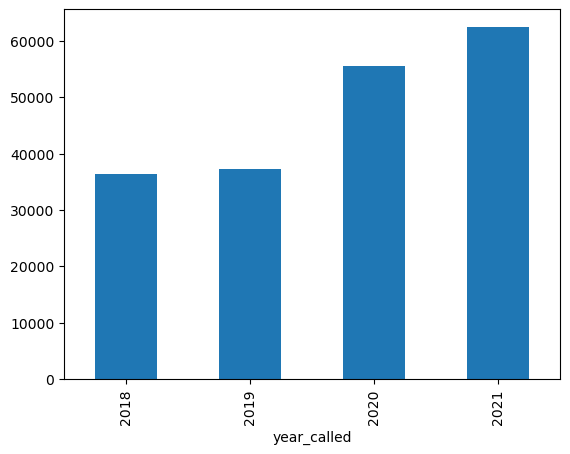

In [53]:
ontopic.year_called.astype(str).value_counts().sort_index().plot(kind='bar')

### shotspotter events

<Axes: xlabel='year_called'>

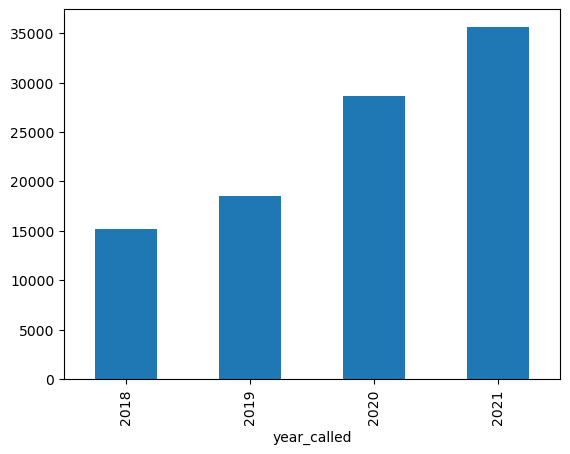

In [54]:
ontopic.loc[ontopic.event_shotspotter].year_called.astype(str).value_counts().sort_index().plot(kind='bar')

### 911 calls about gunfire

<Axes: xlabel='year_called'>

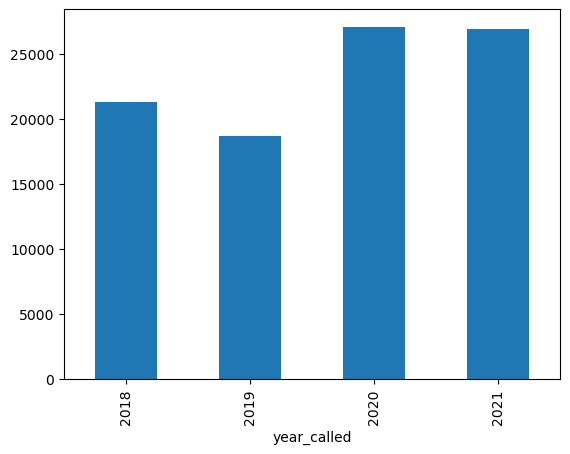

In [55]:
ontopic.loc[ontopic.event_gun].year_called.astype(str).value_counts().sort_index().plot(kind='bar')

### by district

In [56]:
calls_bydist_ss = ontopic.loc[(ontopic.event_shotspotter)
    ].district.value_counts().to_frame(
    ).rename(columns={'count':'total_shotspotter'})
calls_bydist_gun = ontopic.loc[(ontopic.event_gun)
    ].district.value_counts().to_frame(
    ).rename(columns={'count':'total_911gunfire'})
disp_bydist_ss = ontopic.loc[(ontopic.dispatch_reported == 1) & (ontopic.event_shotspotter)
    ].district.value_counts().to_frame(
    ).rename(columns={'count':'disp_reported_shotspotter'})
disp_bydist_gun = ontopic.loc[(ontopic.dispatch_reported == 1) & (ontopic.event_gun)
    ].district.value_counts().to_frame(
    ).rename(columns={'count':'disp_reported_911gunfire'})
disp_counts = pd.concat([
    calls_bydist_ss.T, calls_bydist_gun.T,
    disp_bydist_ss.T, disp_bydist_gun.T]).T.fillna(0)

In [57]:
disp_counts['no_disp_reported_ss'] = disp_counts.total_shotspotter - disp_counts.disp_reported_shotspotter
disp_counts['no_disp_reported_gun'] = disp_counts.total_911gunfire - disp_counts.disp_reported_911gunfire

In [58]:
disp_counts.head(10)

,total_shotspotter,total_911gunfire,disp_reported_shotspotter,disp_reported_911gunfire,no_disp_reported_ss,no_disp_reported_gun
district,,,,,,
004,12885.0,6025.0,12884.0,6018.0,1.0,7.0
005,10187.0,4784.0,10186.0,4779.0,1.0,5.0
008,8922.0,5636.0,8921.0,5608.0,1.0,28.0
011,8714.0,7206.0,8714.0,7193.0,0.0,13.0
007,8676.0,5954.0,8674.0,5945.0,2.0,9.0
006,8328.0,6118.0,8325.0,6089.0,3.0,29.0
009,7856.0,5549.0,7855.0,5545.0,1.0,4.0
003,7614.0,5645.0,7612.0,5638.0,2.0,7.0
025,7475.0,4659.0,7475.0,4653.0,0.0,6.0
